In [61]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
from typing import List, Protocol, Callable, Tuple
from collections import defaultdict 


# Configure JAX
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def create_transverse_hamiltonian(num_wires: int, J: float = 1.0, h: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions
    for i in range(num_wires):
        coeffs.append(-h)
        obs.append(qml.PauliX(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

def create_heisenberg_hamiltonian(num_wires: int, J: float = 1.0):
    coeffs = []
    obs = []

    # Heisenberg interactions (XX + YY + ZZ)
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.extend([-J, -J, -J])
            obs.extend([qml.PauliX(i) @ qml.PauliX(j), qml.PauliY(i) @ qml.PauliY(j), qml.PauliZ(i) @ qml.PauliZ(j)])

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

def create_longitudinal_ising_hamiltonian(num_wires: int, J: float = 1.0, hx: float = 0.5, hz: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions (transverse field)
    for i in range(num_wires):
        coeffs.append(-hx)
        obs.append(qml.PauliX(i))
    
    # Z interactions (longitudinal field)
    for i in range(num_wires):
        coeffs.append(-hz)
        obs.append(qml.PauliZ(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

In [62]:

class Operation(Protocol):
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        ...

class TwoQubitDecomp:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        """Implement an arbitrary SU(4) gate on two qubits
        using the decomposition from Theorem 5 in
        https://arxiv.org/pdf/quant-ph/0308006.pdf"""
        i, j = wires
        qml.Rot(*params[:3], wires=i)
        qml.Rot(*params[3:6], wires=j)
        qml.CNOT(wires=[j, i])
        qml.RZ(params[6], wires=i)
        qml.RY(params[7], wires=j)
        qml.CNOT(wires=[i, j])
        qml.RY(params[8], wires=j)
        qml.CNOT(wires=[j, i])
        qml.Rot(*params[9:12], wires=i)
        qml.Rot(*params[12:15], wires=j)

class PauliRotSequence:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.ArbitraryUnitary(params, wires=wires)

class SpecialUnitaryGate:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.SpecialUnitary(params, wires=wires)

# Initialize parameters
num_wires = 6
num_blocks = 2
num_layers = 2
num_params = 15
loc = 2
learning_rate = 5e-4
num_steps = 500
# init_params = jax.numpy.array(init_params)
# # Define a function that returns a default value for the innermost dictionary
# def nested_dict():
#     return defaultdict(lambda: defaultdict(lambda: [None, None]))

# Initialize the top-level defaultdict
energies = {}

dev = qml.device("default.qubit", wires=num_wires)

#  circuitLauncher
def launch_circuit(hamiltonian_func: Callable[[], Tuple[qml.Hamiltonian, float]]):
    hamiltonian, e_min = hamiltonian_func()
    def circuit(params, operation: Operation):
        for params_block in params:
            for i, params_layer in enumerate(params_block):
                for j, params_op in enumerate(params_layer):
                    wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                    operation.apply(params_op, wires_op)
        return qml.expval(hamiltonian)

    qnode = qml.QNode(circuit, dev, interface="jax")
    return qnode, e_min

# run the loop
def run(operations: List[Tuple[str, Operation]], hamiltonian_funcs: List[Tuple[str, Callable[[], Tuple[qml.Hamiltonian, float]]]]):
    energies = {}
    for hamiltonian_name, hamiltonian_func in hamiltonian_funcs:
        energies[hamiltonian_name] = {}
        for operation_name, operation in operations:
            energies[hamiltonian_name][operation_name] = {}
            qnode, E_min = launch_circuit(hamiltonian_func)
            for num_blocks in range(2,5,2):
                init_params = jax.numpy.array(np.random.randn(num_blocks, num_layers, 3, num_params))
                print(f"Running the optimization for the {operation_name} with {hamiltonian_name} repeats {num_blocks}, E_min {E_min}")
                params = init_params.copy()
                energy = []
                for step in range(1, num_steps+1):
                    cost = qnode(params, operation)
                    params = params - learning_rate * jax.grad(qnode)(params, operation)
                    energy.append(cost)
                    if step % 50 == 0:
                        print(f"{step:3d} Steps: {cost:.6f}")
                #energy.append(qnode(params, operation))
                final_energy = energy[-1]
                energies[hamiltonian_name][operation_name][num_blocks] = [energy, abs(final_energy), E_min]
    return energies
    
if __name__ == "__main__":
    # Example of running the optimization
    hamiltonian_funcs = [("ZZ Hamiltonian", lambda: create_transverse_hamiltonian(num_wires)), 
                         ("Heisenberg Hamiltonian", lambda: create_heisenberg_hamiltonian(num_wires)),
                         ("Longitudinal Ising Hamiltonian", lambda: create_longitudinal_ising_hamiltonian(num_wires))]

    
    operations = [("TwoQubitDecomp", TwoQubitDecomp()), 
                  ("PauliRotSequence", PauliRotSequence()), 
                  ("SpecialUnitaryGate", SpecialUnitaryGate())]

    energies = run(operations, hamiltonian_funcs)


/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


Running the optimization for the TwoQubitDecomp with ZZ Hamiltonian repeats 2, E_min -15.150118797798024
 50 Steps: 0.165388
100 Steps: -0.403754
150 Steps: -1.205771
200 Steps: -2.337316


[Array(2.29379951, dtype=float64), Array(0.52289691, dtype=float64)]
[Array(0.25551596, dtype=float64), Array(1.9703687, dtype=float64)]
[Array(0.48651527, dtype=float64), Array(3.06528267, dtype=float64)]
[Array(1.10963501, dtype=float64), Array(3.10604183, dtype=float64)]
[Array(0.22898586, dtype=float64), Array(2.84523341, dtype=float64)]
[Array(2.0302381, dtype=float64), Array(2.70199293, dtype=float64)]
[Array(0.20776084, dtype=float64), Array(1.71675317, dtype=float64)]
[Array(1.10057202, dtype=float64), Array(0.91749385, dtype=float64)]
[Array(1.53633025, dtype=float64), Array(0.11435121, dtype=float64)]


/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_97430/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', num_operations)
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_97430/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', num_operations)
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_97430/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  co

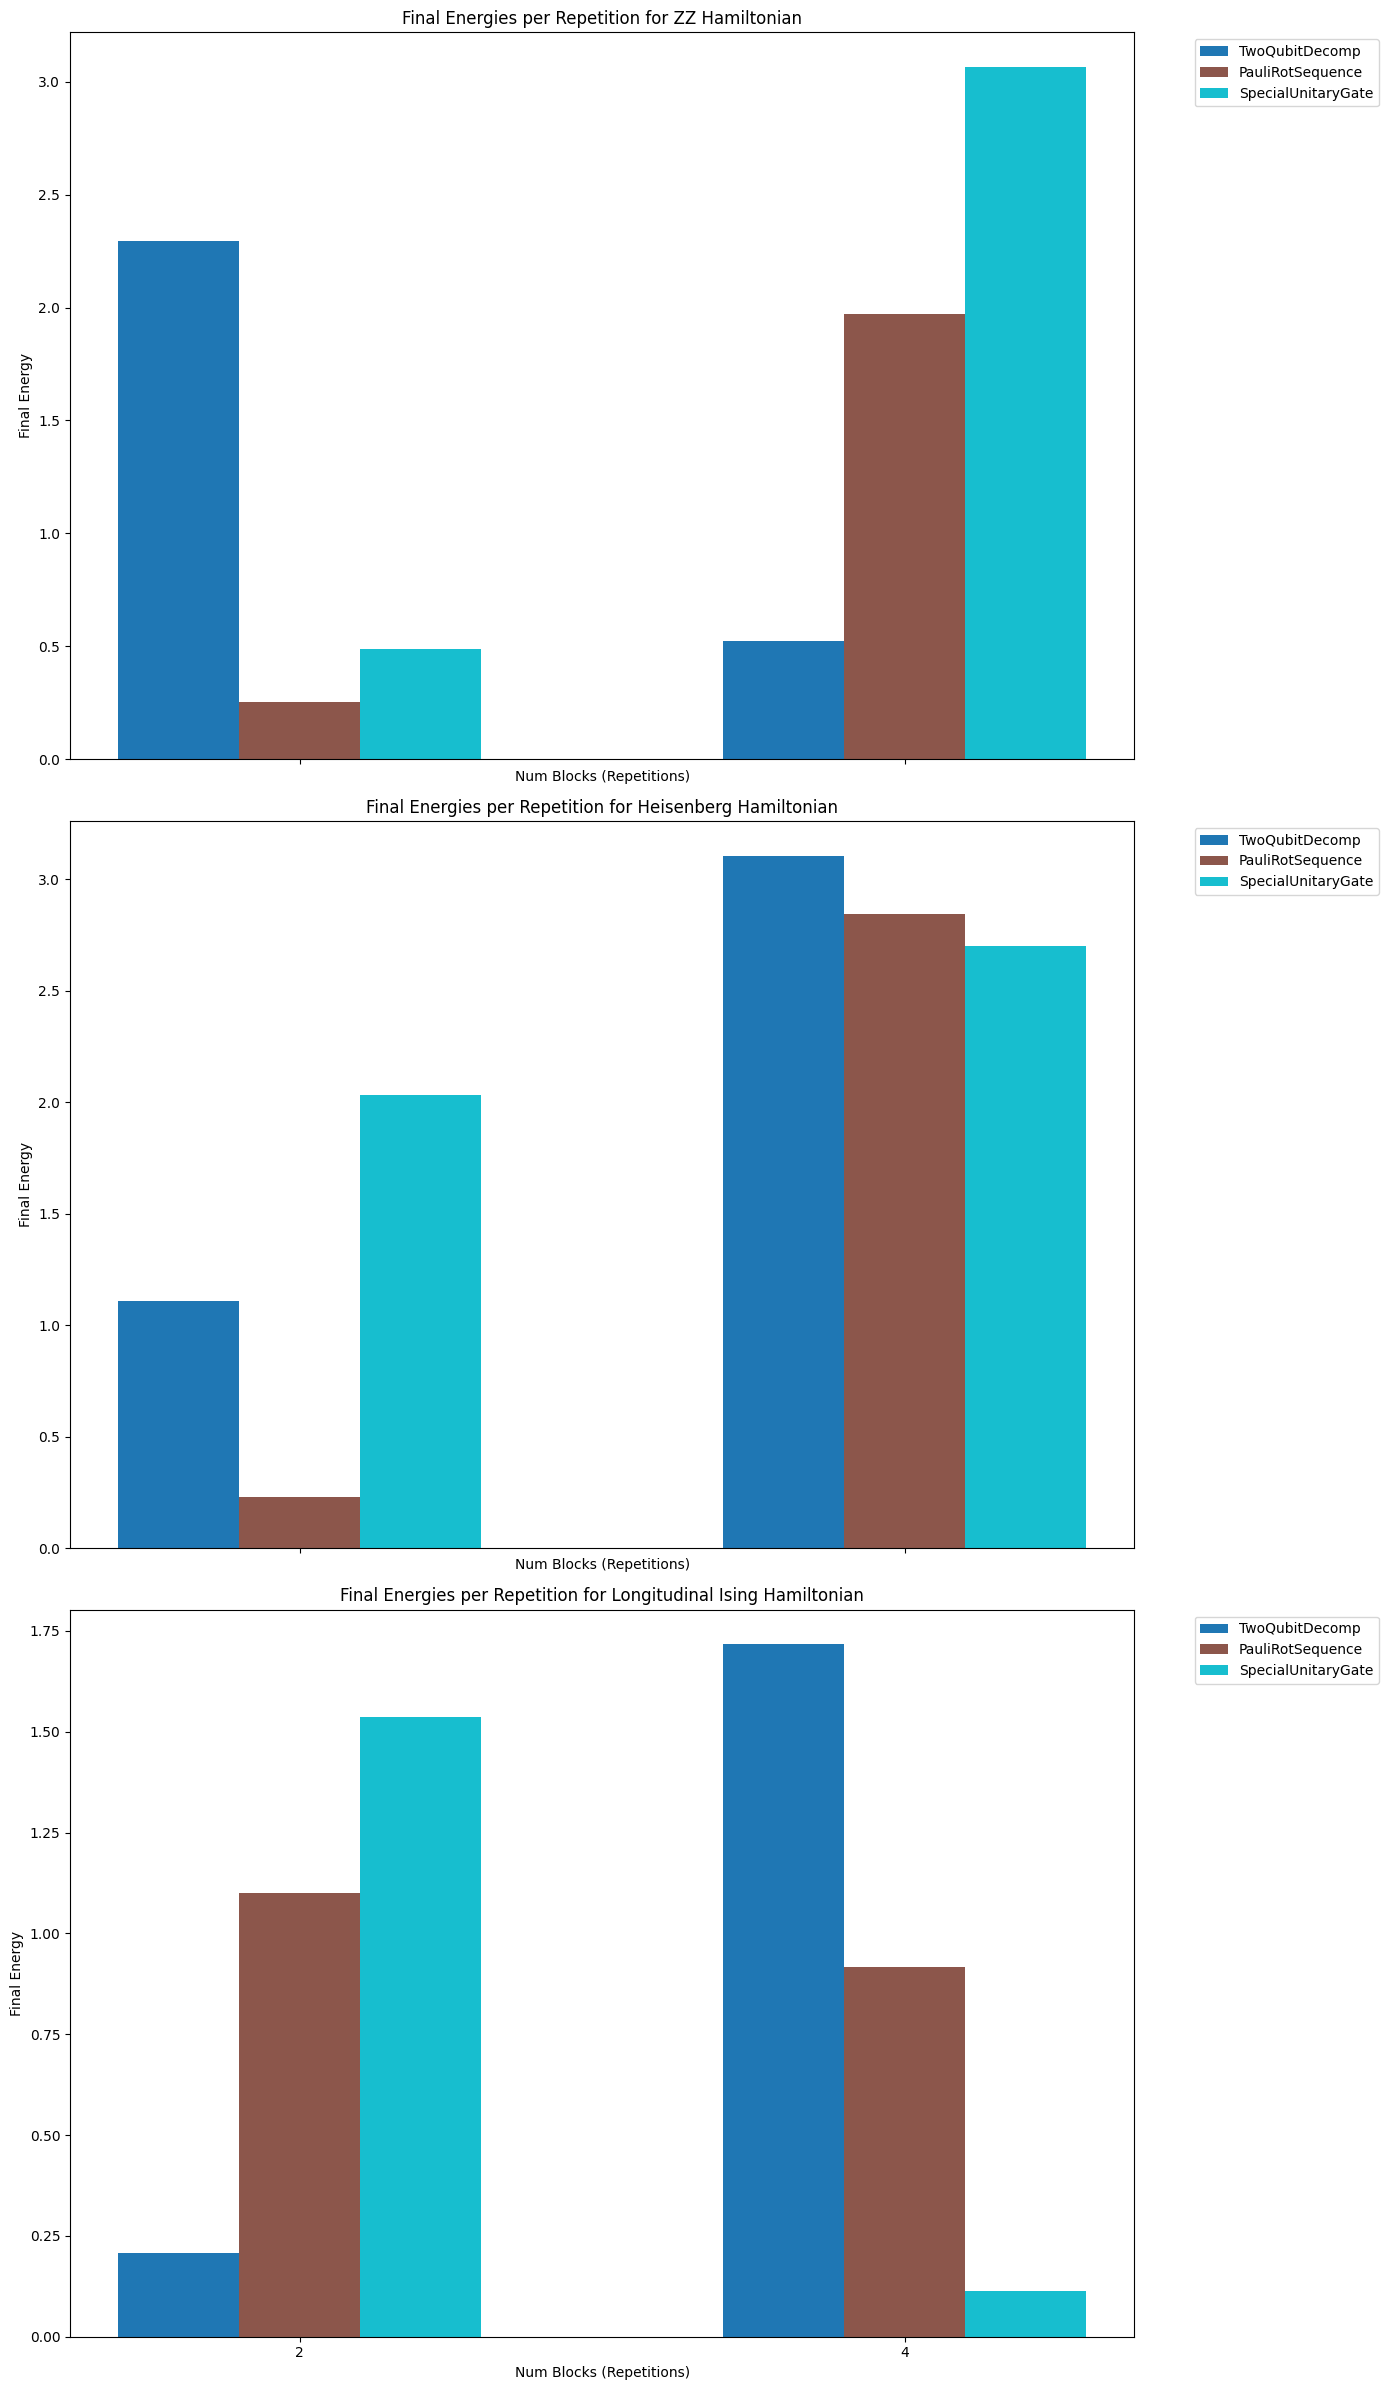

In [56]:
import matplotlib.cm as cm
# Function to plot energies vs repetitions as bar charts grouped by operations and split by Hamiltonians
def plot_energies_vs_repetitions(energies):
    hamiltonians = list(energies.keys())
    num_hamiltonians = len(hamiltonians)

    fig, axes = plt.subplots(num_hamiltonians, 1, figsize=(14, 8 * num_hamiltonians), sharex=True)

    if num_hamiltonians == 1:
        axes = [axes]

    for ax, hamiltonian in zip(axes, hamiltonians):
        operations = energies[hamiltonian]
        data = {}

        # Collect final energy data for each operation and repetition
        for operation, blocks in operations.items():
            if operation not in data:
                data[operation] = {}
            for num_blocks, values in blocks.items():
                final_energy = values[1]
                if num_blocks not in data[operation]:
                    data[operation][num_blocks] = []
                data[operation][num_blocks].append(final_energy)

        # Plotting the bar charts
        bar_width = 0.2
        num_operations = len(data)
        colors = cm.get_cmap('tab10', num_operations)
        
        repetitions = sorted({num_blocks for operation in data for num_blocks in data[operation]})
        positions = np.arange(len(repetitions))

        for idx, (operation, energies_) in enumerate(data.items()):
            final_energies = [energies_[num_block][0] for num_block in repetitions if num_block in energies_]
            print(final_energies)
            bar_positions = positions + idx * bar_width
            ax.bar(bar_positions, final_energies, bar_width, label=operation, color=colors(idx))

        ax.set_xlabel('Num Blocks (Repetitions)')
        ax.set_ylabel('Final Energy')
        ax.set_title(f'Final Energies per Repetition for {hamiltonian}')
        ax.set_xticks(positions + bar_width * (num_operations - 1) / 2)
        ax.set_xticklabels([f'{num_blocks}' for num_blocks in repetitions])
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()# Call the plot function
plot_energies_vs_repetitions(energies)


/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_97430/1631713991.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(energies[next(iter(energies))]))  # Unique colors for each operation


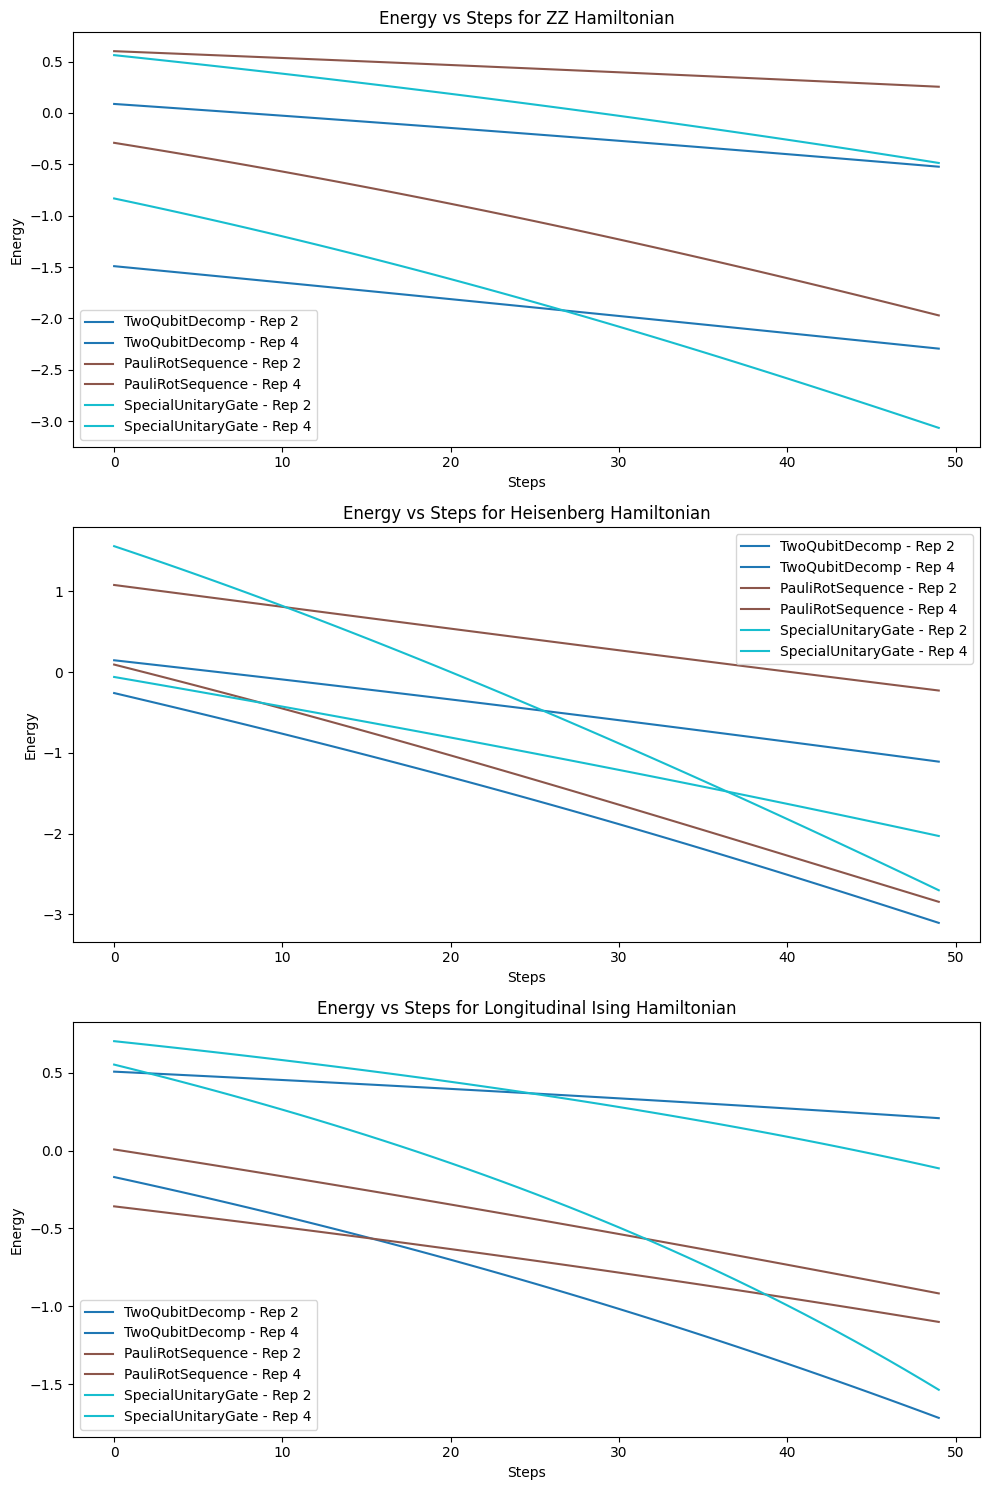

In [58]:
def plot_energy_comparison(energies):
    num_hamiltonians = len(energies)
    fig, axs = plt.subplots(num_hamiltonians, 1, figsize=(10, 5 * num_hamiltonians), squeeze=False)
    
    colors = plt.cm.get_cmap('tab10', len(energies[next(iter(energies))]))  # Unique colors for each operation

    for ax, (hamiltonian_name, operations) in zip(axs.flatten(), energies.items()):
        for i, (operation_name, repetitions) in enumerate(operations.items()):
            for repetition, values in repetitions.items():
                steps = list(range(len(values[0])))  # Steps are the index of the energy values
                energy = values[0]
                ax.plot(steps, energy, label=f"{operation_name} - Rep {repetition}", color=colors(i))
        
        ax.set_xlabel("Steps")
        ax.set_ylabel("Energy")
        ax.set_title(f"Energy vs Steps for {hamiltonian_name}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
plot_energy_comparison(energies)

In [ ]:
def plot_relative_error_comparison(energies):
    num_hamiltonians = len(energies)
    fig, axs = plt.subplots(num_hamiltonians, 1, figsize=(10, 5 * num_hamiltonians), squeeze=False)
    
    operation_colors = {'operation1': 'blue', 'operation2': 'green'}  # Unique colors for each operation

    for ax, (hamiltonian_name, operations) in zip(axs.flatten(), energies.items()):
        for operation_name, repetitions in operations.items():
            for repetition, values in repetitions.items():
                steps = list(range(len(values[0])))  # Steps are the index of the energy values
                energy_values = values[0]
                E_min = values[2]
                E_max = max(energy_values)
                relative_error = [(E - E_min) / (E_max - E_min) for E in energy_values]
                ax.plot(steps, relative_error, label=f"{operation_name} - Rep {repetition}", color=operation_colors[operation_name])
        
        ax.set_xlabel("Steps")
        ax.set_ylabel("Relative Error")
        ax.set_title(f"Relative Error vs Steps for {hamiltonian_name}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_relative_error_comparison(energies)